- 실제 EUR/USD 환율 시계열에 기반한 샘플데이터를 가져온다.

/tmp/ipykernel_888428/1738939314.py:15: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  l = raw.resample('1m').last()


<Axes: title={'center': 'EUR/USD monthly'}, xlabel='Date'>

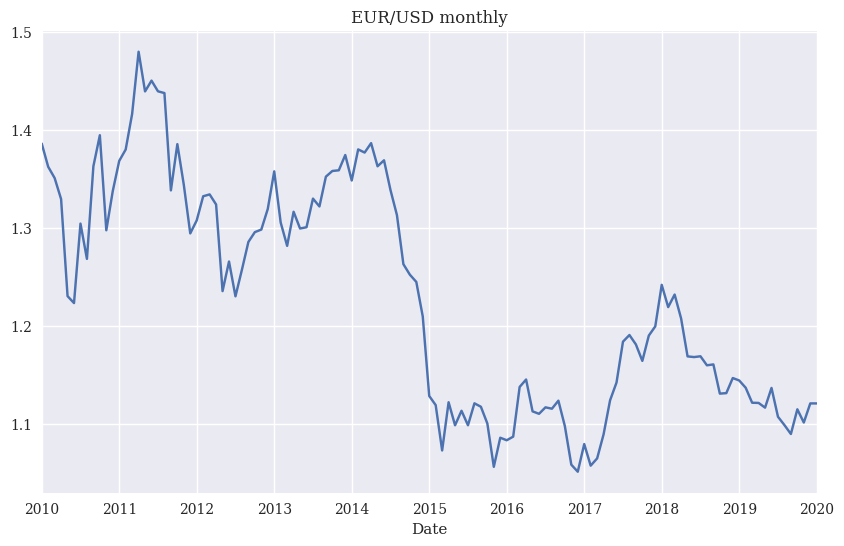

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl

np.random.seed(100)
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# EUR 시계열 데이터를 임포트
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
raw = pd.read_csv(url, index_col=0, parse_dates=True)['EUR=']

# 월간 간격으로 샘플링, 라벨 데이터
l = raw.resample('1m').last()
l.plot(figsize=(10,6),title='EUR/USD monthly')

- 특정 데이터를 하나만 갖도록 만들기 위해 합성 특징벡터를 생성한다.
  - 이렇게 하면 2차원에서 시각화하는 것이 간단해진다.
  - 실제 EUR/USD 환율 (라벨 데이터,종속변수)에 대한 설명력을 갖는건 아니다.

- 다음으로 이 라벨데이터가 순차적이고 시간에 의존하는 데이터라는 사실도 추상화한다.
  - 이 장에서는 샘플데이터가 단순한 1차원 특징 데이터와 1차원 라벨벡터로 되어 있다고 가정한다.

Text(0, 0.5, 'labels')

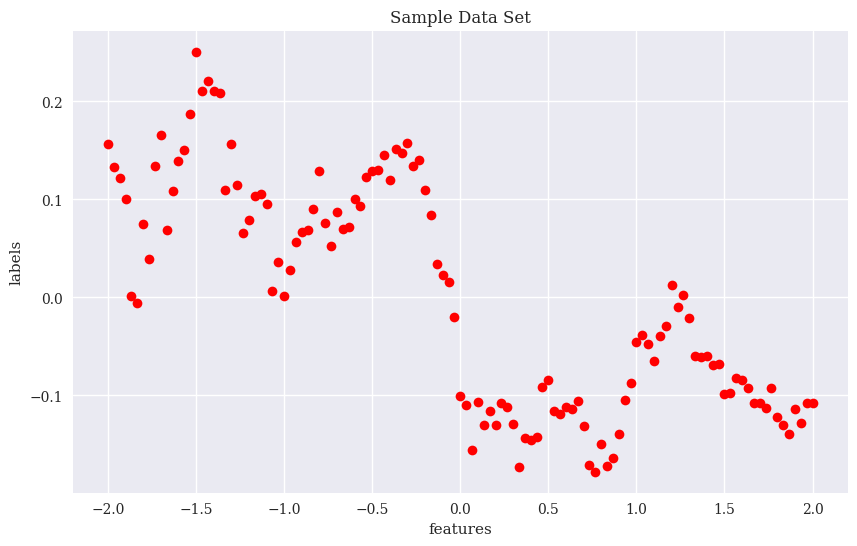

In [2]:
# 라벨 데이터를 ndarray 객체로 변환
l = l.values

# 평균값을 제거: 데이터가 0을 기준으로 위아래로 나타남
l -= l.mean()

# 합성 특징을 -2에서 2사이의 값으로 l개의 ndarray 객체로 생성
f = np.linspace(-2,2,len(l))

plt.figure(figsize=(10,6))
plt.plot(f, l, 'ro')
plt.title('Sample Data Set')
plt.xlabel('features')
plt.ylabel('labels')

- 추정 문제의 성공 측도는 일반적으로 평균제곱오차
  - 벤치마크로 라벨 데이터가 주어졌을 때, 이 데이터의 일부에 대한 평균제곱오차에 근거하여 성공 여부를 판단한다.

- 이제부터는 회귀분석과 신경망에 대해서 설명한다.

##### 회귀분석
- 5차의 회귀분석

[-0.01910626 -0.0147182   0.10990388  0.06007211 -0.20833598 -0.03275423]
1.009648372165024


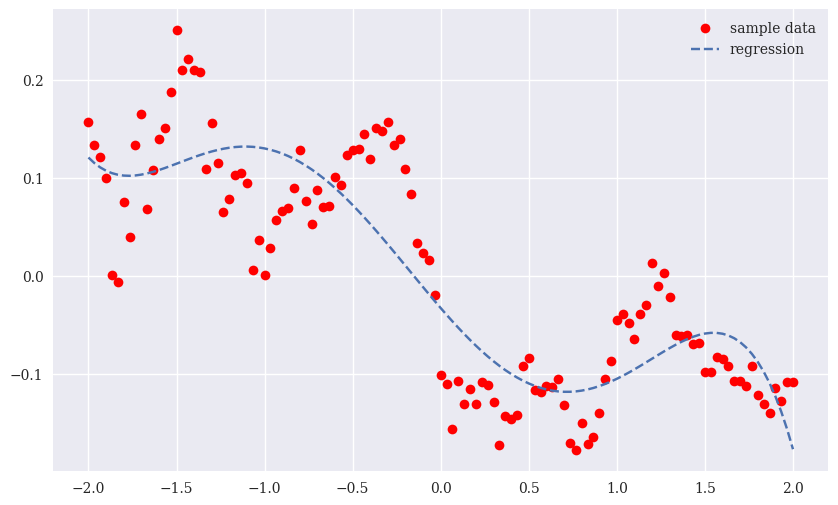

In [3]:
# 평균제곱오차를 계산하는 함수
def MSE(l,p):
    return np.mean((l - p) ** 2)

# 5차항을 포함하는 회귀분석
reg = np.polyfit(f, l, deg=5)
print(reg)

# 주어진 최적인수를 사용하여 회귀분석 모형에 의한 예측
p = np.polyval(reg, f)

# 예측값에 대한 평균 오차
print(MSE(1, p))

plt.figure(figsize=(10,6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='regression')
plt.legend()

- 회귀분석은 일반적으로 분석적 방법으로 해결되므로 반복 학습이 일어나지 않는다. 하지만 데이터를 알고리즘에 점점 더 많이 노출하는 방법으로 반복 학습 과정을 시뮬레이션할 수 있다.
  - 일반적으로 학습에 사용되는 데이터의 수가 증가할수록 평균제곱오차는 크게 감소한다.

In [4]:
""" 다음 파이선 코드는 처음에는 몇 개의 데이터만 사용하여 회귀분석을 하다가, 
   학습에 사용하는 데이터의 수를 점점 늘리는 방법으로 최종적으로 전체 데이터셋을
   사용하게끔 한다."""
   
for i in range(10, len(f) + 1, 20):
    # 데이터의 일부분을 사용하는 회귀분석 단계
    reg = np.polyfit(f[:i], l[:i], deg=3)
    # 전체 데이터를 사용하는 예측 단계
    p = np.polyval(reg, f)
    # 평균제곱오차
    mse = MSE(l, p)
    
    print(f'{i:3d} | MSE={mse}')

 10 | MSE=248628.10681642307
 30 | MSE=731.9382249304656
 50 | MSE=12.236088505004469
 70 | MSE=0.7410590619743299
 90 | MSE=0.005743061730409331
110 | MSE=0.006492800939555579


- 이번에는 신경망을 이용하여 샘플 데이터를 근사화해보자.

In [5]:
import tensorflow as tf
tf.random.set_seed(100)

from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

# 단일 은닉층을 가진 얕은 신경망
model.add(Dense(256, activation='relu', input_dim=1))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()


# 학습 단계에서 많은 에포크 수를 사용한다.
%time model.fit(f, l, epochs=1500, verbose=False)

# 마찬가지로 flatten한 ndarray 객체를 사용하는 예측 단계
p = model.predict(f).flatten()

# 예측 결과에 대한 평균제곱오차
print(MSE(l,p))

2025-06-09 01:41:46.798197: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 01:41:46.801617: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 01:41:46.808324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749397306.820616  888428 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749397306.824360  888428 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749397306.834825  888428 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 41.3 s, sys: 7.5 s, total: 48.8 s
Wall time: 43.4 s
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
0.0021767780454213003


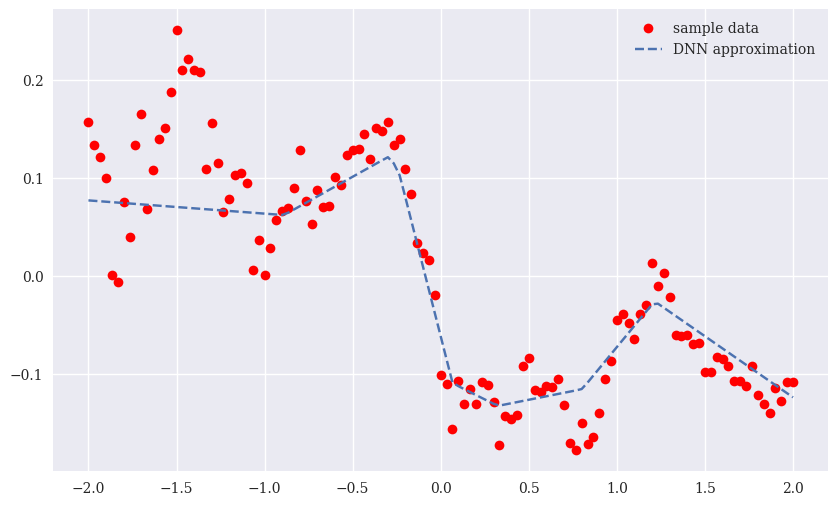

In [6]:
plt.figure(figsize=(10,6))
plt.plot(f,l,'ro',label='sample data')
plt.plot(f,p,'--',label='DNN approximation')
plt.legend()

- Keras 패키지를 사용하면, 매 학습 단계의 (평균제곱)오차를 저장할 수 있다.
  - 다음의 코드는 이를 이용하여 신경망이 학습되면서 평균제곱오차가 평균적으로 감소하는 모습을 보여준다.

Text(0.5, 0, 'epochs')

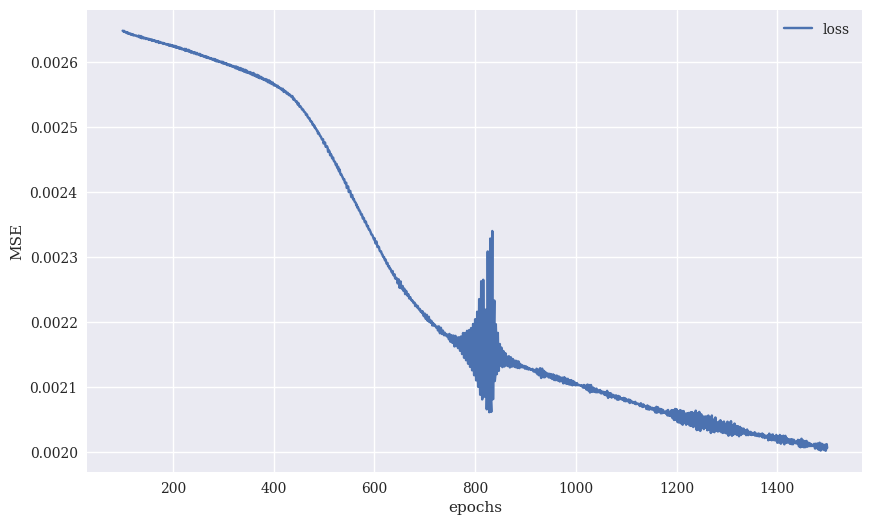

In [7]:
import pandas as pd
res = pd.DataFrame(model.history.history)
res.iloc[100:].plot(figsize=(10,6))
plt.ylabel('MSE')
plt.xlabel('epochs')

/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 1min 14s, sys: 13.1 s, total: 1min 27s
Wall time: 1min 15s
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


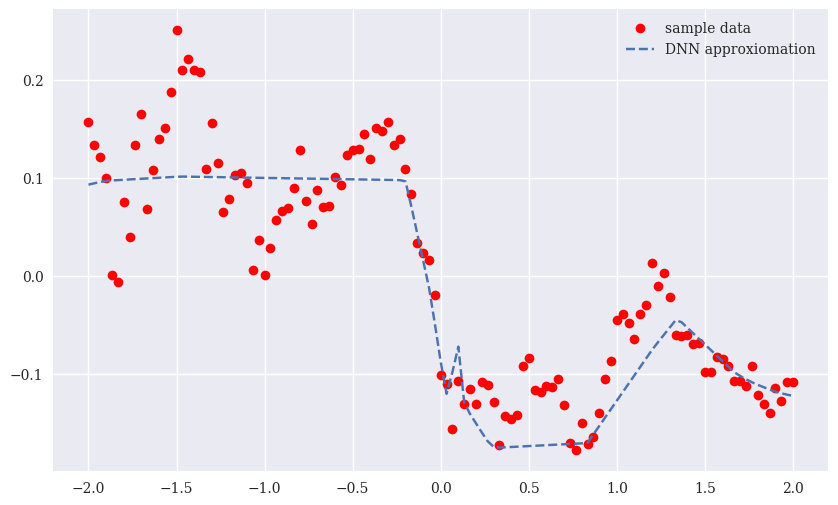

In [8]:
""" 같은 크기의 은닉층을 하나 더 추가하면 학습 가능한 파라미터의 수는 큰폭으로 증가한다. """
def create_dnn_model(hl=1, hu=256):
    '''Function to create Keras DNN model.
    Parameters
    ==========
    hl: int
        number of hidden layers
    hu: int
        number of hidden units (per layer)
    '''
    model = Sequential()
    for _ in range(hl):
        # 신경망에 더 많은 은닉층을 더할 수 있도록 변경
        model.add(Dense(hu, activation='relu', input_dim=1))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='rmsprop')
    return model

# 은닉층 3개를 갖는 깊은 신경망
model = create_dnn_model(3)

# 학습 가능한 파라미터의 수가 증가(용량 증가)함을 보여줌
model.summary()

%time model.fit(f, l, epochs=2500, verbose=False) # 2500 회 실행
p = model.predict(f).flatten() # 만들어진 모델로 예측
MSE(l,p) # label 데이터와 예측치를 비교

plt.figure(figsize=(10,6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='DNN approxiomation')
plt.legend()

In [9]:
''' 다음의 파이썬 코드는 샘플 데이터의 25%를 데스트에, 25%는 검증용으로, 나머지 50%는 학습 자체에 사용한다. '''

# 데스트 데이터셋의 데이터 갯수
te = int(0.25 * len(f))
# 검증 데이터셋의 데이터 갯수
va = int(0.25 * len(f))

np.random.seed(100)

# 전체 데이터에 대한 무작위 인덱스
ind = np.arange(len(f))
np.random.shuffle(ind)

# 정렬된 인덱스 적용
ind_te = np.sort(ind[:te])
ind_va = np.sort(ind[te:te+va])
ind_tr = np.sort(ind[te+va:])

# 결과로 나온 특정 데이터셋
f_te = f[ind_te]
f_va = f[ind_va]
f_tr = f[ind_tr]

# 결과로 나온 라벨 데이터셋
l_te = l[ind_te]
l_va = l[ind_va]
l_tr = l[ind_tr]

여러가지 차수의 회귀분석을 이용하여 검증데이터에 대한 평균제곱 오차를 구한다.
- 차수가 증가할수록 학습 데이터에 대한 평균제곱오차는 계속 감소하지만, 검증 데이터에 대한
      평균제곱오차는 종종 특정한 차수값에 대해서 가장 작은 값을 보이다가 다시 증가하는 모습을
      보이기도 한다.

 1 | MSE_tr=0.00574 | MSE_va=0.00492
 5 | MSE_tr=0.00375 | MSE_va=0.00273
 9 | MSE_tr=0.00132 | MSE_va=0.00243
13 | MSE_tr=0.00094 | MSE_va=0.00183
17 | MSE_tr=0.00060 | MSE_va=0.00153
21 | MSE_tr=0.00046 | MSE_va=0.00837


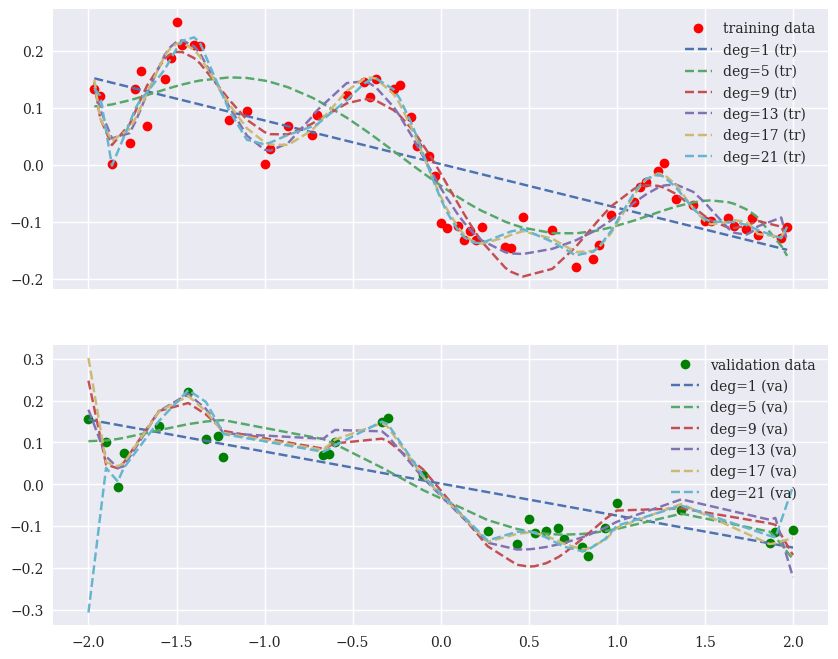

In [10]:
reg = {}
mse = {}
for d in range(1, 22, 4):
    reg[d] = np.polyfit(f_tr, l_tr, deg=d)
    p = np.polyval(reg[d], f_tr)
    mse_tr = MSE(l_tr, p) # 학습 데이터에 대한 평균제곱오차
    p = np.polyval(reg[d], f_va)
    mse_va = MSE(l_va, p) # 검증 데이터에 대한 평균제곱오차
    mse[d] = (mse_tr, mse_va)
    print(f'{d:2d} | MSE_tr={mse_tr:7.5f} | MSE_va={mse_va:7.5f}')
    
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
ax[1].plot(f_va, l_va, 'go', label='validation data')
for d in reg:
    p = np.polyval(reg[d], f_tr)
    ax[0].plot(f_tr, p, '--', label=f'deg={d} (tr)')
    p = np.polyval(reg[d], f_va)
    plt.plot(f_va, p, '--', label=f'deg={d} (va)')
ax[0].legend()
ax[1].legend()

Keras와 신경망 모형을 사용하면 각 학습 단계마다 검증 데이터의 성능을 모니터할 수 있다.
- 콜백 함수라는 것을 이용하면 학습 데이터의 성능에 더 이상 진전이 보이지 않은 경우 정해진 
학습 회수 이전에도 조기에 학습을 중히라 수도 있다.

In [ ]:
from keras.callbacks import EarlyStopping
model = create_dnn_model(2, 256)
callbacks = [EarlyStopping(monitor='loss', # 학습 데이터에 대한 평균제곱오차 값에 기반하여 학습 중지
                          patience=100, # 특정 값 이상의 향상을 정해진 확습 회수 내에 보이지 못하면 중지
                          restore_best_weights=True)] # 학습이 중지되면 최고의 가중치값을 복원

%time
model.fit(f_tr, l_tr, epochs=3000, verbose=False,
          validation_data=(f_va, l_va), # 검증 데이터셋 설정
          callbacks=callbacks) # fit() 메서드에 콜백 함수 설정

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 22.9 μs


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f71147d1760> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


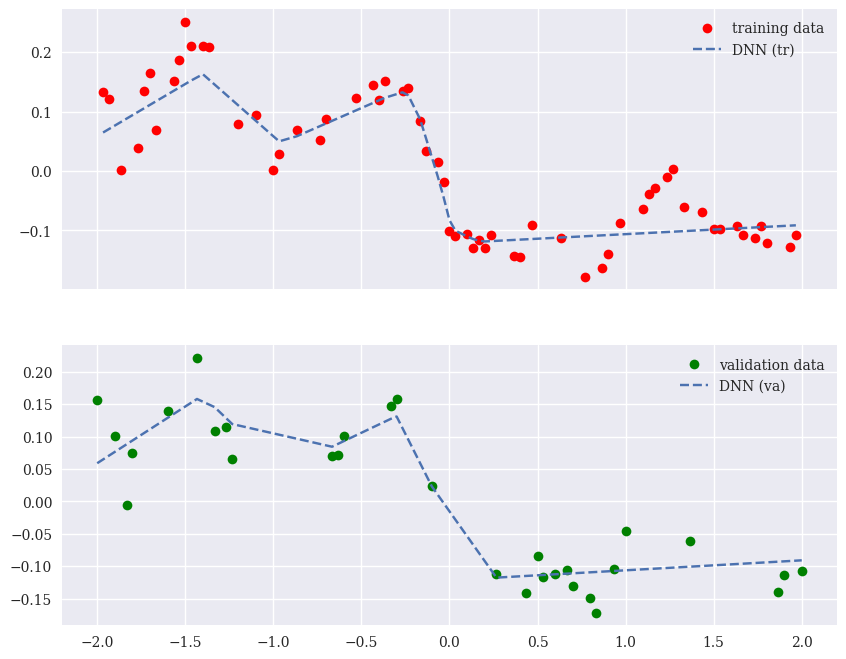

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
p = model.predict(f_tr)
ax[0].plot(f_tr, p, '--', label=f'DNN (tr)')
ax[0].legend()
ax[1].plot(f_va, l_va, 'go', label='validation data')
p = model.predict(f_va)
ax[1].plot(f_va, p, '--', label=f'DNN (va)')
ax[1].legend()

Keras는 두 데이터셋에 대해 모형학습이 발생하는 에포크에 대한 평균제곱오차의 변화를 분석할 수도 있다.

          loss  val_loss
2995  0.001833  0.001487
2996  0.001877  0.001465
2997  0.001832  0.001515
2998  0.001853  0.001476
2999  0.001898  0.001463


Text(0.5, 0, 'epochs')

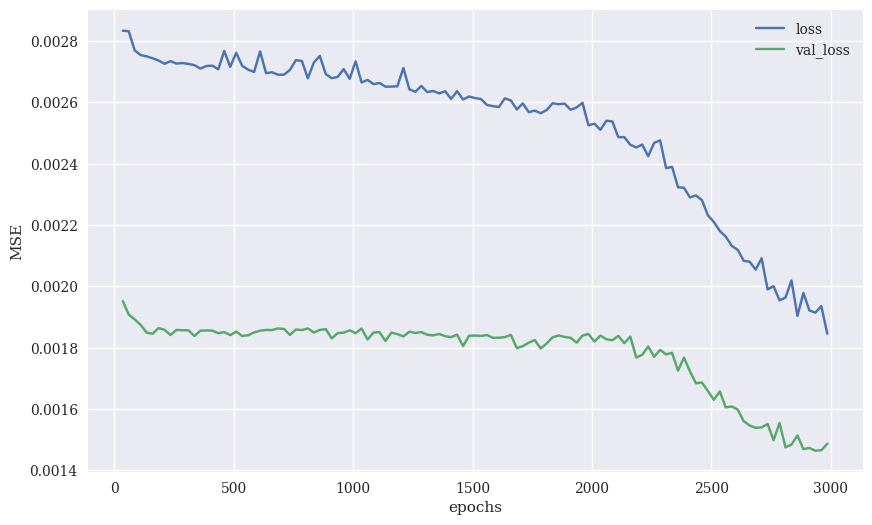

In [ ]:
res = pd.DataFrame(model.history.history)
res.iloc[35::25].plot(figsize=(10,6))
print(res.tail())
plt.ylabel('MSE')
plt.xlabel('epochs')

회귀분석도 차수를 선택할 때, 높기는 하지만 너무 높지 않은 값, 예를 들어 9차와 같은 값을 선택할 수 있다.
- 다음의 코드는 두 가지 모형의 예측을 서로 비교하고 있다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
회귀분석의 예측: 0.0038960346771028326
신경망의 예측, 0.0017978592904705868


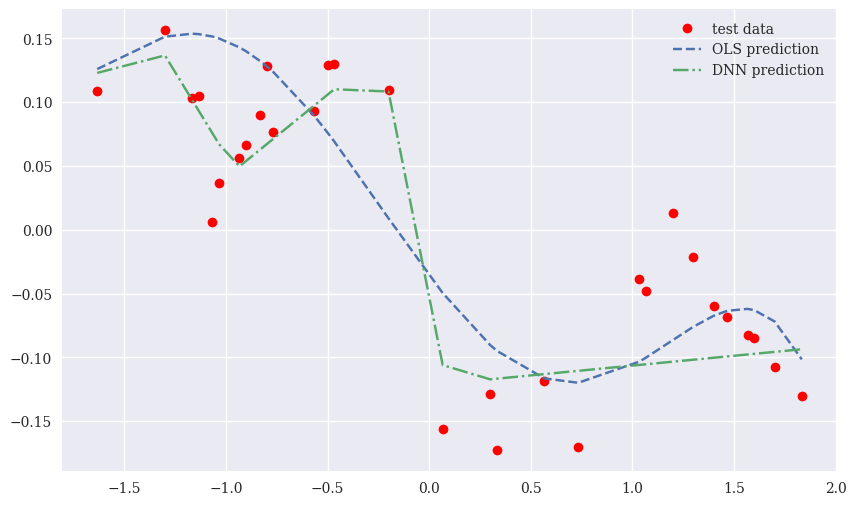

In [ ]:
p_ols = np.polyval(reg[5], f_te)
p_dnn = model.predict(f_te).flatten()

print("회귀분석의 예측:", MSE(l_te, p_ols))
print("신경망의 예측,", MSE(l_te, p_dnn))

plt.figure(figsize=(10,6))
plt.plot(f_te, l_te, 'ro', label='test data')
plt.plot(f_te, p_ols, '--', label='OLS prediction')
plt.plot(f_te, p_dnn, '-.', label='DNN prediction')
plt.legend()

편향과 분산
- 머신러닝 알고리즘을 금융에 적용할 때 underfit와 overfit가 발생할 수 있다.
  - 편향이 높으면 underfitting을 의미하고
  - 분산이 높으면 overfitting을 의미한다.

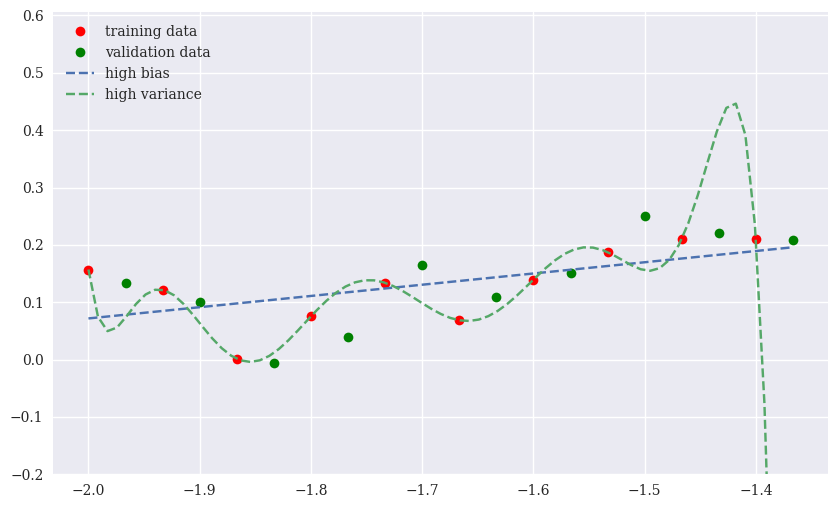

In [ ]:
# 더 적은 개수의 특징 데이터
f_tr = f[:20:2] # 처음부터 20 이전까지, 2칸씩 건너뛰며 선택
l_tr = l[:20:2]

# 더 적은 개수의 라벨 데이터
f_va = f[1:20:2] # 1번 인덱스부터 20 이전까지, 2칸씩 건너뛰며 선택
l_va = l[1:20:2]

# 높은 회귀분석 편향, 모델이 단순하여 underfitting 발생
reg_b = np.polyfit(f_tr, l_tr, deg=1)

# 높은 회귀분석 분산, 모델이 복잡해서 uverfitting 발생
reg_v = np.polyfit(f_tr, l_tr, deg=9, full=True)[0]

# plot를 위해 더 많은 데이터를 사용
f_ = np.linspace(f_tr.min(), f_va.max(), 75)

plt.figure(figsize=(10,6))
plt.plot(f_tr, l_tr, 'ro', label='training data')
plt.plot(f_va, l_va, 'go', label='validation data')
plt.plot(f_, np.polyval(reg_b, f_), '--', label='high bias')
plt.plot(f_, np.polyval(reg_v, f_), '--', label='high variance')
plt.ylim(-0.2)
plt.legend(loc=2)

- 편향이 높은 경우, 학습데이터에 대한 성능이 좋지 않다. (underfitting)
- 분산이 높은 경우, 검증데이터에 대한 성능이 좋지 않다. (overfitting)
- 결정계수를 사용하여 모델의 설명력을 평가할 수 있다.

In [ ]:
''' 평균제곱오차와 결정계수 R**2을 구하는 코드 '''
from sklearn.metrics import r2_score

def evaluate(reg, f, l):
    p = np.polyval(reg, f)
    
    # 평균절대차이(mean absolute difference)로 구한 모델 편향
    bias = np.abs(l - p).mean()
    # 모델 예측값의 분산으로 구한 모델 분산
    var = p.var()
    msg = f'MSG={MSE(l,p):.4f} | R2={r2_score(l,p):9.4f} | bias={bias:4f} | var={var:.4f}'
    print(msg)
    
# 높은 편향을 가진 모델의 학습 데이터에 대한 성능
evaluate(reg_b, f_tr, l_tr)
# 높은 편향을 가진 모델의 검증 데이터에 대한 성능
evaluate(reg_b, f_va, l_va)
# 높은 분산을 가진 모델의 학습 데이터에 대한 성능
evaluate(reg_v, f_tr, l_tr)
# 높은 분산을 가진 모델의 검증 데이터에 대한 성능
evaluate(reg_v, f_va, l_va)

MSG=0.0026 | R2=   0.3484 | bias=0.042279 | var=0.0014
MSG=0.0032 | R2=   0.4498 | bias=0.046033 | var=0.0014
MSG=0.0000 | R2=   1.0000 | bias=0.000003 | var=0.0040
MSG=0.8752 | R2=-149.2664 | bias=0.356503 | var=0.7539


In [ ]:
''' 전체 샘플 데이터에 대해 가장 높은 차수의 회귀분석모델에 대해 5배수 교차검증을 구현'''

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 회귀분석 모델 클래스 생성
def PolynomialRegression(degree=None, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

# numpy 디폴트 출력 설정 변경
np.set_printoptions(suppress=True, formatter={'float': lambda x: f'{x:12.2f}'})

print('\nCross-validation scores')
print(74 * '=')
for deg in range(0,10,1):
    model = PolynomialRegression(deg)
    
    # 5배수 교차검증 실시
    cvs = cross_val_score(model, f.reshape(-1,1), l, cv=5)
    print(f'deg={deg} | ' + str(cvs.round(2)))


Cross-validation scores
deg=0 | [       -6.07        -7.34        -0.09        -6.32        -8.69]
deg=1 | [       -0.28        -1.40         0.16        -1.66        -4.62]
deg=2 | [       -3.48        -2.45         0.19        -1.57       -12.94]
deg=3 | [       -0.00        -1.24         0.32        -0.48       -43.62]
deg=4 | [     -222.81        -2.88         0.37        -0.32      -496.61]
deg=5 | [     -143.67        -5.85         0.49         0.12     -1241.04]
deg=6 | [    -4038.96       -14.71         0.49        -0.33      -317.32]
deg=7 | [    -9937.83       -13.98         0.64         0.22    -18725.61]
deg=8 | [    -3514.36       -11.22        -0.15        -6.29   -298744.18]
deg=9 | [    -7454.15        -0.91         0.15        -0.41    -13580.75]


In [ ]:
np.random.seed(100)
tf.random.set_seed(100)
from scikeras.wrappers import KerasRegressor

# 용량이 작은 신경망의 래퍼 클래스
model = KerasRegressor(build_fn=create_dnn_model, verbose=False, epochs=1000, hl=1, hu=36) 

# 용량이 작은 신경망의 교차검증
%time cross_val_score(model, f, l, cv=5)

# 용량이 큰 신경망의 레퍼 클래스
model = KerasRegressor(build_fn=create_dnn_model, verbose=False, epochs=1000, hl=3, hu=256)

# 용량이 큰 신경망의 교차검증
%time cross_val_score(model, f, l, cv=5)

ModuleNotFoundError: No module named 'keras.wrappers.scikit_learn'